0 -----------------
num_steps 1000
1 -----------------
num_steps 1000
2 -----------------
num_steps 1000
3 -----------------
num_steps 1000
4 -----------------
num_steps 1000
5 -----------------
0.0
0.95
1.8073749999999997
2.5811559374999997
3.2794932335937492
3.909742643318358
4.478542735594818
4.991884818874323
5.873296384253252
6.250649986788559
6.591211613076674
6.898568480801698
7.175958053923532
7.426302143665987
7.6522376846585525
7.856144510404344
8.04017042063992
8.206253804627526
8.356144058676342
8.491520012955398
8.613596811692247
8.723771122552252
8.823303438103407
9.913031352888323
10.89651079598171
11.351685256182623
11.784100993373492
12.194895943704818
12.585151146519577
12.955893589193597
13.308098909733916
13.64269396424722
13.960559266034858
14.262531302733114
14.549404737596458
14.549404737596458
14.821934500716635
15.080837775680802
15.326795886896761
15.326795886896761
15.560456092551922
15.782433287924325
15.993311623528108
16.193646042351702
16.383963740234115


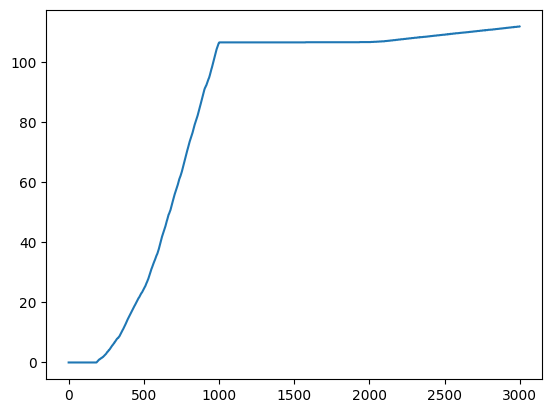

In [216]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt

class Maze:
    def __init__(self) -> None:
        self.height = 6
        self.width = 9
        self.obstacles_before = {
            (2,0),
            (2,1),
            (2,2),
            (2,3),
            (2,4),
            (2,5),
            (2,6),
            (2,7),
        }
        self.obstacles_after = {
            (2,1),
            (2,2),
            (2,3),
            (2,4),
            (2,5),
            (2,6),
            (2,7),
            (2,8),
        }
        self.start = (0,3)
        self.target = (5,8)
        self.pos = self.start

    def state_shape(self):
        return (self.height, self.width)
    
    def action_shape(self):
        return 4
    
    def reset(self):
        self.pos = self.start
        return self.pos
    
    def step(self, action, num_steps):
        '''if self.pos == self.target:
            #self.pos = self.start
            return True, 0, self.pos'''
        y = self.pos[0]
        x = self.pos[1]
        match action:
            case 0:#up
                y = min(y + 1, self.height - 1)
            case 1:#down
                y = max(y - 1, 0)
            case 2:#right
                x = min(x + 1, self.width - 1)
            case 3:#left
                x = max(x - 1, 0)
        obstacles = self.obstacles_before if num_steps < 1000 else self.obstacles_after
        if num_steps == 1000:
            print("num_steps", num_steps)
        if (y,x) not in obstacles:
            self.pos = (y,x)
        terminated, reward = (True, 1) if self.pos == self.target else (False, 0)
        return terminated, reward, self.pos


class Model:
    def __init__(self) -> None:
        self.model = {}

    def update(self, state, action, reward, next_state):
        if state not in self.model:
            self.model[state] = {}
        self.model[state][action] = (reward, next_state)

    def sample(self):
        #state = random.sample(list(self.model.keys()),1)[0]
        #action = random.sample(list(self.model[state]),1)[0]
        state = list(self.model.keys())[np.random.choice(len(self.model))]
        action = list(self.model[state])[np.random.choice(len(self.model[state]))]
        reward, next_state = self.model[state][action]
        return state, action, reward, next_state

class Model_Plus:
    def __init__(self, k) -> None:
        self.k = k
        self.model = {}

    def update(self, state, action, reward, next_state, cur_step):
        if state not in self.model:
            self.model[state] = {}
        self.model[state][action] = (reward, next_state, cur_step)

    def sample(self, cur_step):
        state = list(self.model.keys())[np.random.choice(len(self.model))]
        action = list(self.model[state])[np.random.choice(len(self.model[state]))]
        reward, next_state, prev_step = self.model[state][action]
        bonus = self.k * math.sqrt(cur_step - prev_step)
        self.model[state][action] = (reward, next_state, cur_step)
        return state, action, reward, next_state, bonus
    

def epsilon_greedy(qs, epsilon):
    if np.random.random() < epsilon:
        return np.random.choice(len(qs))
    else:
        m = qs.max()
        indices = [i for i in range(len(qs)) if m - qs[i] < 0.00001]
        return np.random.choice(indices)#slow
        #return qs.argmax()
    

def dyna_q(env, num_steps, planning_steps, alpha = 1.0, epsilon = 0.1, gamma = 0.95, callback=None):
    state_shape = env.state_shape()
    action_shape = env.action_shape()
    q_shape = state_shape + (action_shape,)
    qs = np.zeros(q_shape)
    model = Model()
    reward_stat = np.zeros(num_steps)
    acc_step = 0
    acc_rewards = 0
    while acc_step < num_steps:
        state = env.reset()
        while acc_step < num_steps:
            action = epsilon_greedy(qs[state], epsilon)
            terminated, reward, next_state = env.step(action,acc_step)
            model.update(state, action, reward, next_state)
            acc_rewards += reward
            #v_prime = 0 if terminated else qs[next_state].max()
            v_prime = qs[next_state].max()
            qs[state][action] += (reward + v_prime * gamma - qs[state][action]) * alpha
            for _ in range(planning_steps):
                s, a, r, n = model.sample()
                v_prime = qs[n].max()
                qs[s][a] += (r + v_prime * gamma - qs[s][a]) * alpha
            state = next_state
            reward_stat[acc_step] = acc_rewards
            acc_step += 1
            if terminated:
                break
    return reward_stat


def dyna_q_plus(env, num_steps, planning_steps, k, alpha = 1.0, epsilon = 0.1, gamma = 0.95, callback=None):
    state_shape = env.state_shape()
    action_shape = env.action_shape()
    q_shape = state_shape + (action_shape,)
    qs = np.zeros(q_shape)
    model = Model_Plus(k)
    reward_stat = np.zeros(num_steps)
    acc_step = 0
    acc_rewards = 0
    while acc_step < num_steps:
        state = env.reset()
        while acc_step < num_steps:
            action = epsilon_greedy(qs[state], epsilon)
            terminated, reward, next_state = env.step(action,acc_step)
            model.update(state, action, reward, next_state, acc_step)
            acc_rewards += reward
            #v_prime = 0 if terminated else qs[next_state].max()
            v_prime = qs[next_state].max()
            qs[state][action] += (reward + v_prime * gamma - qs[state][action]) * alpha
            for _ in range(planning_steps):
                s, a, r, n, b = model.sample(acc_step)
                v_prime = qs[n].max()
                qs[s][a] += (r + b + v_prime * gamma - qs[s][a]) * alpha
            state = next_state
            reward_stat[acc_step] = acc_rewards
            acc_step += 1
            if terminated and acc_step > 1000:
                break
    return reward_stat

env = Maze()

num_repetitions = 20
num_steps = 3000
avg_reward_stat = np.zeros(num_steps)
for n in range(num_repetitions):
    #np.random.seed(n)
    print(n, "-----------------")
    reward_stat = dyna_q_plus(env, num_steps, 10, 1e-4)
    #reward_stat = dyna_q(env, num_steps, 10)
    avg_reward_stat += reward_stat
avg_reward_stat /= num_repetitions
plt.plot(range(len(avg_reward_stat)),avg_reward_stat);
